<a href="https://colab.research.google.com/github/keunjoopark/NYC-taxi-trip-duration/blob/master/Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load the Data

In [1]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import missingno as msno
import datetime as dt
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 10]

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
train_df = pd.read_csv('/content/drive/My Drive/dt/train.csv')
test_df = pd.read_csv('/content/drive/My Drive/dt/test.csv')

In [4]:
train_df.shape

(1458644, 11)

In [5]:
test_df.shape

(625134, 9)

# Features

In [6]:
# For time extraction
train_df['pickup_datetime'] = pd.to_datetime(train_df.pickup_datetime)
test_df['pickup_datetime'] = pd.to_datetime(test_df.pickup_datetime)
#train_df['dropoff_datetime'] = pd.to_datetime(train_df.dropoff_datetime)
test_df['pickup_datetime'] = pd.to_datetime(test_df.pickup_datetime)

In [7]:
train_df['log_trip_duration'] = np.log(train_df['trip_duration'].values + 1)

In [8]:
# check days

from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
import time
from datetime import timedelta


for df in (train_df,test_df):

    # Load a list of holidays in the US
    calendar = USFederalHolidayCalendar()
    holidays = calendar.holidays()

    # Load business days
    us_bd = CustomBusinessDay(calendar = USFederalHolidayCalendar())
    business_days = pd.date_range(start = df.pickup_datetime.min(), 
                                     end = df.pickup_datetime.max(), 
                                     freq = us_bd)
    business_days = pd.to_datetime(business_days).date
    
    # Dates
    #df['pickup_date'] = df['pickup_datetime'].dt.date

    # day of month 1 to 30/31
    df['pickup_day'] = df['pickup_datetime'].dt.day

    # month of year 1 to 12
    df['pickup_month'] = df['pickup_datetime'].dt.month

    # Weekday 0 to 6
    df['pickup_weekday'] = df['pickup_datetime'].dt.weekday
    
    # weekend
    df['pickup_is_weekend'] = df.pickup_weekday.map(lambda x: 1 if x >= 5 else 0)
    
    # holiday
    df['pickup_holiday'] = pd.to_datetime(df.pickup_datetime.dt.date).isin(holidays)
    df['pickup_holiday'] = df.pickup_holiday.map(lambda x: 1 if x == True else 0)
    
    # If day is before or after a holiday
    df['pickup_near_holiday'] = (pd.to_datetime(df.pickup_datetime.dt.date).isin(holidays + timedelta(days=1)) |
                                 pd.to_datetime(df.pickup_datetime.dt.date).isin(holidays - timedelta(days=1)))
    df['pickup_near_holiday'] = df.pickup_near_holiday.map(lambda x: 1 if x == True else 0)
    df['pickup_businessday'] = pd.to_datetime(df.pickup_datetime.dt.date).isin(business_days)
    df['pickup_businessday'] = df.pickup_businessday.map(lambda x: 1 if x == True else 0)

    # day of week
    df['pickup_dayofweek'] = df['pickup_datetime'].dt.dayofweek
    
    df['pickup_time_delta'] = (df['pickup_datetime'] - df['pickup_datetime'].min()).dt.total_seconds()
    
    df['week_delta'] = df['pickup_datetime'].dt.weekday + \
                        ((df['pickup_datetime'].dt.hour + \
                        (df['pickup_datetime'].dt.minute / 60.0)) / 24.0)

    #week of year
    df['pickup_weekofyear'] = df['pickup_datetime'].dt.weekofyear

    #hour of day 0 to 23
    df['pickup_hour'] = df['pickup_datetime'].dt.hour

    #hour: 19~24
    df['pickup_is_night'] = [1 if (i==0 or i>=19)  else 0 for i in df['pickup_datetime'].dt.hour]
    
    #hour: 24~4
    df['pickup_is_latenight'] = [1 if (i<5 or i>=0)  else 0 for i in df['pickup_datetime'].dt.hour]


    #minute of hour
    df['pickup_minute'] = df['pickup_datetime'].dt.minute
    
    # day of year
    df['pickup_dayofyear'] = df['pickup_datetime'].dt.dayofyear
    
    # make weekday and hour cyclic, since we want to let machine understand 
    df.pickup_hour = df.pickup_hour.astype('int')
    df['week_delta_sin'] = np.sin((df['week_delta'] / 7) * np.pi)**2
    df['pickup_hour_sin'] = np.sin((df['pickup_hour'] / 24) * np.pi)**2

    # Calculate what minute in a day the pickup is at
    df['pickup_minuteoftheday'] = df.pickup_datetime.dt.hour*60 + df.pickup_datetime.dt.minute
    df['pickup_dt'] = (df['pickup_datetime'] - df['pickup_datetime'].min()).dt.total_seconds()
    df['pickup_week_hour'] = df['pickup_weekday'] * 24 + df['pickup_hour']

In [9]:
from sklearn.cluster import MiniBatchKMeans

# get lon & lat clustering for following avg location speed calculation
def get_clustering(df):
    coords = np.vstack((train_df[['pickup_latitude', 'pickup_longitude']].values,
                    train_df[['dropoff_latitude', 'dropoff_longitude']].values,
                    test_df[['pickup_latitude', 'pickup_longitude']].values,
                    test_df[['dropoff_latitude', 'dropoff_longitude']].values))
    df_ = df.copy()
    sample_ind = np.random.permutation(len(coords))[:500000]
    kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])
    df_.loc[:, 'pickup_cluster'] = kmeans.predict(df_[['pickup_latitude', 'pickup_longitude']])
    df_.loc[:, 'dropoff_cluster'] = kmeans.predict(df_[['dropoff_latitude', 'dropoff_longitude']])
    return df_


def trip_cluser_count(df):
    df_ = df.copy()
    df_.pickup_datetime = pd.to_datetime(df_.pickup_datetime)
    group_freq = '60min'
    df_dropoff_counts = df_ \
        .set_index('pickup_datetime') \
        .groupby([pd.Grouper(freq='M'), 'dropoff_cluster']) \
        .agg({'id': 'count'}) \
        .reset_index().set_index('pickup_datetime') \
        .groupby('dropoff_cluster').rolling('240min').mean() \
        .drop('dropoff_cluster', axis=1) \
        .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
        .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'dropoff_cluster_count'})
        
    df_['pickup_datetime_group'] = df_['pickup_datetime'].dt.round(group_freq)
    df_['dropoff_cluster_count'] = \
            df_[['pickup_datetime_group', 'dropoff_cluster']]\
            .merge(df_dropoff_counts,on=['pickup_datetime_group', 'dropoff_cluster'], how='left')\
            ['dropoff_cluster_count'].fillna(0)
            
    return df_

In [10]:
# get lon & lat clustering 
train_df= get_clustering(train_df)
test_df= get_clustering(test_df)
# get avg ride count on dropoff cluster 
train_df = trip_cluser_count(train_df)
test_df = trip_cluser_count(test_df)

In [11]:
#from haversine import haversine

#train_df['haversine_distance'] = train_df.apply(lambda row: haversine( (row['pickup_latitude'], row['pickup_longitude']), (row['dropoff_latitude'], row['dropoff_longitude']) ), axis=1)
#test_df['haversine_distance'] = test_df.apply(lambda row: haversine( (row['pickup_latitude'], row['pickup_longitude']), (row['dropoff_latitude'], row['dropoff_longitude']) ), axis=1)

# Haversine distance
def get_haversine_distance(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  #  km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h 

# Manhattan distance
# Taxi cant fly ! have to move in blocks/roads
def get_manhattan_distance(lat1, lng1, lat2, lng2):
    # km 
    a = get_haversine_distance(lat1, lng1, lat1, lng2)
    b = get_haversine_distance(lat1, lng1, lat2, lng1)
    return a + b

  
# get direction (arc tangent angle)
def get_direction(lat1, lng1, lat2, lng2):
    # theta
    AVG_EARTH_RADIUS = 6371  
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

def gat_trip_center(df):
    df_ = df.copy()
    df_.loc[:, 'center_latitude'] = (df_['pickup_latitude'].values + df_['dropoff_latitude'].values) / 2
    df_.loc[:, 'center_longitude'] = (df_['pickup_longitude'].values + df_['dropoff_longitude'].values) / 2
    return df_



### ======================== ###

def get_features(df):
    # km 
    df_ = df.copy()
    ###  USING .loc making return array ordering 
    # distance
    df_.loc[:, 'distance_haversine'] = get_haversine_distance(
                                      df_['pickup_latitude'].values,
                                      df_['pickup_longitude'].values,
                                      df_['dropoff_latitude'].values,
                                      df_['dropoff_longitude'].values)
    df_.loc[:, 'distance_manhattan'] = get_manhattan_distance(
                                      df_['pickup_latitude'].values,
                                      df_['pickup_longitude'].values,
                                      df_['dropoff_latitude'].values,
                                      df_['dropoff_longitude'].values)
    # direction 
    df_.loc[:, 'direction'] = get_direction(df_['pickup_latitude'].values,
                                          df_['pickup_longitude'].values, 
                                          df_['dropoff_latitude'].values, 
                                          df_['dropoff_longitude'].values)
    return df_

In [12]:
# get other features 
train_df = get_features(train_df)
test_df = get_features(test_df)
# get center of trip route 
train_df = gat_trip_center(train_df)
test_df = gat_trip_center(test_df)

In [13]:
train_df.loc[:, 'avg_speed_h'] = 3600 * train_df['distance_haversine'] / train_df['trip_duration']
train_df.loc[:, 'avg_speed_m'] = 3600 * train_df['distance_manhattan'] / train_df['trip_duration']

In [14]:
# avg speed on cluster 
def avg_cluser_speed(df):
    df_ = df.copy()
    # avg speed on cluster 
    avg_cluser_h = df_.groupby(['pickup_cluster','dropoff_cluster']).mean()['avg_speed_h'].reset_index()
    avg_cluser_h.columns = ['pickup_cluster','dropoff_cluster','avg_speed_cluster_h']
    avg_cluser_m = df_.groupby(['pickup_cluster','dropoff_cluster']).mean()['avg_speed_m'].reset_index()
    avg_cluser_m.columns = ['pickup_cluster','dropoff_cluster','avg_speed_cluster_m']
    # merge dataframe
    df_ = pd.merge(df_,avg_cluser_h, how = 'left', on = ['pickup_cluster','dropoff_cluster'])
    df_ = pd.merge(df_,avg_cluser_m, how = 'left', on = ['pickup_cluster','dropoff_cluster'])
    return df_


# avg duration on cluster 
def avg_cluser_duration(df):
    df_ = df.copy()
    # avg speed on cluster 
    avg_cluser_duration = df_.groupby(['pickup_cluster','dropoff_cluster']).mean()['trip_duration'].reset_index()
    avg_cluser_duration.columns = ['pickup_cluster','dropoff_cluster','avg_cluster_duration']
    # merge dataframe
    df_ = pd.merge(df_,avg_cluser_duration, how = 'left', on = ['pickup_cluster','dropoff_cluster'])
    return df_


def avg_cluster_speed_(df):
    df_ = df.copy()
    # only get pickup_cluster first as test here 
    for gby_col in ['pickup_cluster']:
        gby = df_.groupby(gby_col).mean()[['avg_speed_h', 'avg_speed_m', 'trip_duration']]
        gby.columns = ['%s_gby_%s' % (col, gby_col) for col in gby.columns]
        df_ = pd.merge(df_, gby, how='left', left_on=gby_col, right_index=True)
        #df_test = pd.merge(df_test, gby, how='left', left_on=gby_col, right_index=True)
    for gby_cols in [
                 ['pickup_cluster', 'dropoff_cluster']]:
        coord_speed = df_.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
        coord_count = df_.groupby(gby_cols).count()[['id']].reset_index()
        coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
        #coord_stats = coord_stats[coord_stats['id'] > 100]
        coord_stats.columns = gby_cols + ['avg_speed_h_%s' % '_'.join(gby_cols), 'cnt_%s' %  '_'.join(gby_cols)]
        df_ = pd.merge(df_, coord_stats, how='left', on=gby_cols)
    return df_


In [15]:
# get avg cluster speed 
train_df  = avg_cluser_speed(train_df)
train_df  = avg_cluser_duration(train_df)
train_df = avg_cluster_speed_(train_df)

In [17]:
train_df.shape

(1458644, 52)

In [18]:
test_df.shape

(625134, 39)

# Model

Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE)

$$ \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 } $$
${n}$ is the number of hours in the test set $p_i$ is your predicted count $a_i$ is the actual count $\log(x)$ is the natural logarithm

In [19]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

## Feature Prep.

In [20]:
# check trip_duration outliers
print((train_df['trip_duration']/3600).describe(),'\n')

count    1.458644e+06
mean     2.665256e-01
std      1.454842e+00
min      2.777778e-04
25%      1.102778e-01
50%      1.838889e-01
75%      2.986111e-01
max      9.795228e+02
Name: trip_duration, dtype: float64 



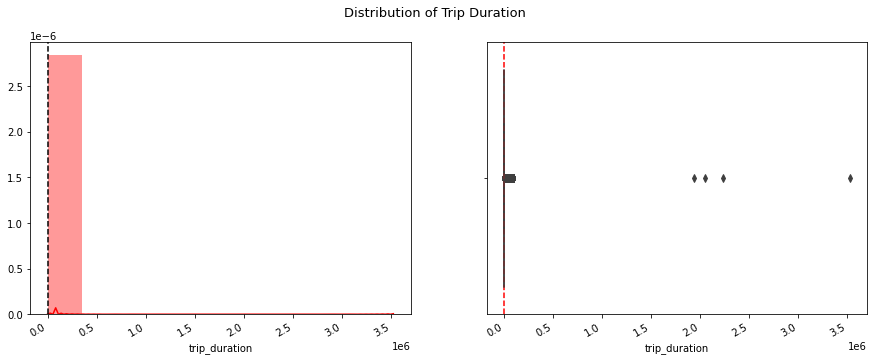

In [21]:
plt.figure(figsize=(15, 5))
plt.suptitle("Distribution of Trip Duration", fontsize=13)

plt.subplot(121)
sns.distplot(train_df["trip_duration"], color="r",bins=10)
plt.axvline(train_df["trip_duration"].median(), linestyle='dashed', color="k")
plt.xticks(rotation=30, ha='right')

plt.subplot(122)
sns.boxplot(train_df["trip_duration"])
plt.axvline(train_df["trip_duration"].median(), linestyle='dashed', color="r")
plt.xticks(rotation=30, ha='right')

plt.show()

In [23]:
# if Trip duration is over 500 hours, those data will not use 
train_df = train_df[train_df["trip_duration"] < 1500000]

In [22]:
# check passenger count outliers
train_df = train_df[(train_df['passenger_count']  <= 6) & (train_df['passenger_count'] > 0)]

In [24]:
# Valid passenger count if 1 to 6, not 0
train_df = train_df[(train_df['passenger_count']  <= 6) & (train_df['passenger_count'] > 0)]

In [25]:
# Make store_and_fwd_flag to be binary 0 or 1
train_df['store_and_fwd_flag'] = 1 * (train_df.store_and_fwd_flag.values == 'Y')
test_df['store_and_fwd_flag'] = 1 * (test_df.store_and_fwd_flag.values == 'Y')

In [28]:
train_df = train_df.drop(['pickup_datetime'], axis=1)
test_df = test_df.drop(['pickup_datetime'], axis=1)
print(train_df.shape, test_df.shape)

(1458575, 51) (625134, 38)


In [29]:
train_df = train_df.drop(['pickup_datetime_group'], axis=1)
test_df = test_df.drop(['pickup_datetime_group'], axis=1)
print(train_df.shape, test_df.shape)

(1458575, 50) (625134, 37)


In [30]:
print(train_df.info(), test_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458575 entries, 0 to 1458643
Data columns (total 50 columns):
 #   Column                                      Non-Null Count    Dtype  
---  ------                                      --------------    -----  
 0   id                                          1458575 non-null  object 
 1   vendor_id                                   1458575 non-null  int64  
 2   dropoff_datetime                            1458575 non-null  object 
 3   passenger_count                             1458575 non-null  int64  
 4   pickup_longitude                            1458575 non-null  float64
 5   pickup_latitude                             1458575 non-null  float64
 6   dropoff_longitude                           1458575 non-null  float64
 7   dropoff_latitude                            1458575 non-null  float64
 8   store_and_fwd_flag                          1458575 non-null  int64  
 9   trip_duration                               1458575 non-n

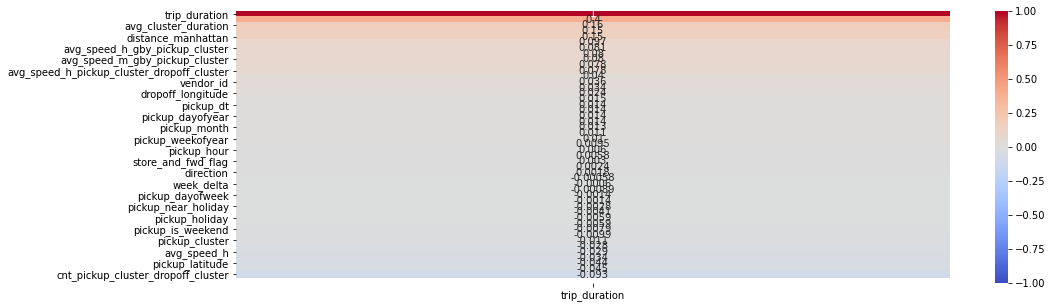

In [31]:
corr_matrix = train_df.corr()
top_corr_features = corr_matrix.index
plt.figure(figsize=(16,5))
sns.heatmap(corr_matrix[['trip_duration']].sort_values(by=['trip_duration'],ascending=False),
            vmin=-1,
            cmap='coolwarm',
            annot=True)

In [32]:
print(np.setdiff1d(train_df.columns, test_df.columns))

['avg_cluster_duration' 'avg_speed_cluster_h' 'avg_speed_cluster_m'
 'avg_speed_h' 'avg_speed_h_gby_pickup_cluster'
 'avg_speed_h_pickup_cluster_dropoff_cluster' 'avg_speed_m'
 'avg_speed_m_gby_pickup_cluster' 'cnt_pickup_cluster_dropoff_cluster'
 'dropoff_datetime' 'log_trip_duration' 'trip_duration'
 'trip_duration_gby_pickup_cluster']


In [33]:
print([i for i in train_df.columns if i in test_df.columns])

['id', 'vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_day', 'pickup_month', 'pickup_weekday', 'pickup_is_weekend', 'pickup_holiday', 'pickup_near_holiday', 'pickup_businessday', 'pickup_dayofweek', 'pickup_time_delta', 'week_delta', 'pickup_weekofyear', 'pickup_hour', 'pickup_is_night', 'pickup_is_latenight', 'pickup_minute', 'pickup_dayofyear', 'week_delta_sin', 'pickup_hour_sin', 'pickup_minuteoftheday', 'pickup_dt', 'pickup_week_hour', 'pickup_cluster', 'dropoff_cluster', 'dropoff_cluster_count', 'distance_haversine', 'distance_manhattan', 'direction', 'center_latitude', 'center_longitude']


In [34]:
#features = [i for i in train_df.columns if i in test_df.columns]
features = [ 'vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_day', 'pickup_month', 'pickup_weekday', 'pickup_is_weekend', 'pickup_holiday', 'pickup_near_holiday', 'pickup_businessday', 'pickup_dayofweek', 'pickup_time_delta', 'week_delta', 'pickup_weekofyear', 'pickup_hour', 'pickup_is_night', 'pickup_is_latenight', 'pickup_minute', 'pickup_dayofyear', 'week_delta_sin', 'pickup_hour_sin', 'pickup_minuteoftheday', 'pickup_dt', 'pickup_week_hour', 'pickup_cluster', 'dropoff_cluster', 'dropoff_cluster_count', 'distance_haversine', 'distance_manhattan', 'direction', 'center_latitude', 'center_longitude']

In [35]:
target =['log_trip_duration']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(train_df[features], train_df['log_trip_duration'], test_size=0.25, random_state=42)

## XGBoost

In [37]:
import xgboost as xgb

### XGB Model 1

In [38]:
dtrain1 = xgb.DMatrix(X_train, label=y_train)
dtest1 = xgb.DMatrix(X_test, label=y_test)

In [39]:
watchlist = [(dtrain1, 'train'), (dtest1, 'valid')]

xgb_pars1 = {'min_child_weight': 50, 
            'eta': 0.3, 
            'colsample_bytree': 0.3, 
            'max_depth': 10,
            'subsample': 0.8, 
            'lambda': 1., 
            'nthread': 4, 
            'booster' : 'gbtree', 
            'silent': 1,
            'eval_metric': 'rmse', 
            'objective': 'reg:linear'}

In [40]:
model1 = xgb.train(xgb_pars1, dtrain1, 60, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)

[0]	train-rmse:4.24685	valid-rmse:4.24592
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.441607	valid-rmse:0.445525
[20]	train-rmse:0.391021	valid-rmse:0.400262
[30]	train-rmse:0.380758	valid-rmse:0.393966
[40]	train-rmse:0.372757	valid-rmse:0.389395
[50]	train-rmse:0.367999	valid-rmse:0.38752
[59]	train-rmse:0.364319	valid-rmse:0.38621


In [41]:
t0 = dt.datetime.now()

In [43]:
print('Modeling RMSLE %.5f' % model1.best_score)
t1 = dt.datetime.now()
print('Training time: %i seconds' % (t1 - t0).seconds)

Modeling RMSLE 0.38616
Training time: 7 seconds


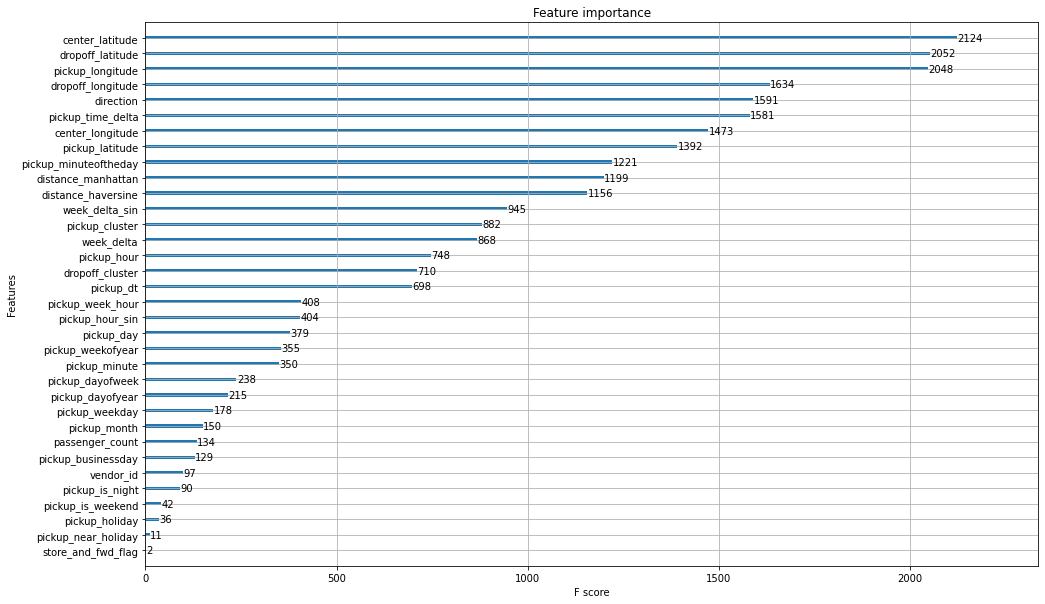

In [44]:
xgb.plot_importance(model1)

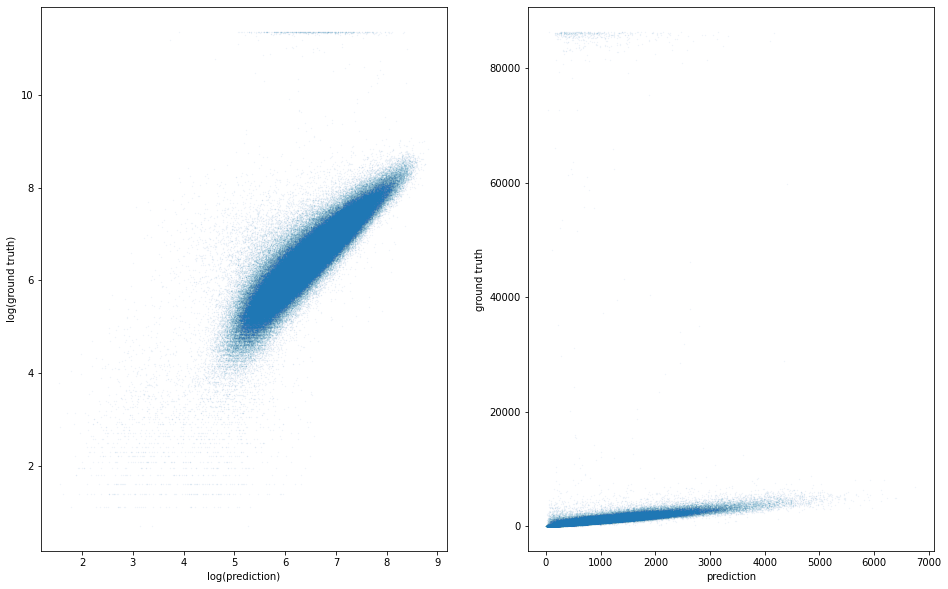

In [45]:
ypred1 = model1.predict(dtest1)
fig,ax = plt.subplots(ncols=2)
ax[0].scatter(ypred1, y_test, s=0.1, alpha=0.1)
ax[0].set_xlabel('log(prediction)')
ax[0].set_ylabel('log(ground truth)')
ax[1].scatter(np.exp(ypred1), np.exp(y_test), s=0.1, alpha=0.1)
ax[1].set_xlabel('prediction')
ax[1].set_ylabel('ground truth')
plt.show()

In [47]:
ftest1 = xgb.DMatrix(test_df[features])

Test shape OK.
Valid prediction mean: 6.467
Test prediction mean: 6.468


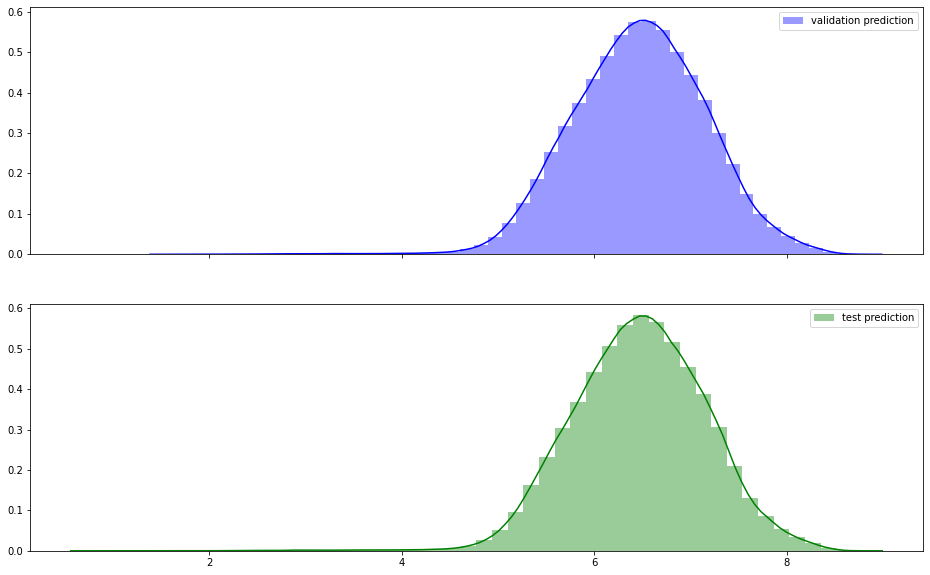

Total time: 37 seconds


In [48]:
ytest1 = model1.predict(ftest1)
print('Test shape OK.') if test_df.shape[0] == ytest1.shape[0] else print('Oops')
test_df['trip_duration'] = np.exp(ytest1) - 1
test_df[['id', 'trip_duration']].to_csv('/content/drive/My Drive/dt/model1.csv', index=False)

print('Valid prediction mean: %.3f' % ypred1.mean())
print('Test prediction mean: %.3f' % ytest1.mean())

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
sns.distplot(ypred1, ax=ax[0], color='blue', label='validation prediction')
sns.distplot(ytest1, ax=ax[1], color='green', label='test prediction')
ax[0].legend(loc=0)
ax[1].legend(loc=0)
plt.show()

t1 = dt.datetime.now()
print('Total time: %i seconds' % (t1 - t0).seconds)

### XGB Model 2

In [49]:
xgb_pars2 = { 'booster':'gbtree',
    'objective':'reg:linear',
    'learning_rate': 0.1,
    'max_depth':14,
    'subsample':0.8,
    'eval_metric': 'rmse',
    'colsample_bytree':0.7,
    'colsample_bylevel':0.7,
    'silent':1
}

In [50]:
model2 = xgb.train(xgb_pars2, dtrain1, 60, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)

[0]	train-rmse:5.42174	valid-rmse:5.42094
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:1.93164	valid-rmse:1.93334
[20]	train-rmse:0.759005	valid-rmse:0.772747
[30]	train-rmse:0.416418	valid-rmse:0.455251
[40]	train-rmse:0.334927	valid-rmse:0.395381
[50]	train-rmse:0.309337	valid-rmse:0.385059
[59]	train-rmse:0.29719	valid-rmse:0.382662


In [51]:
print('Modeling RMSLE %.5f' % model2.best_score)
t1 = dt.datetime.now()
print('Training time: %i seconds' % (t1 - t0).seconds)

Modeling RMSLE 0.38266
Training time: 472 seconds


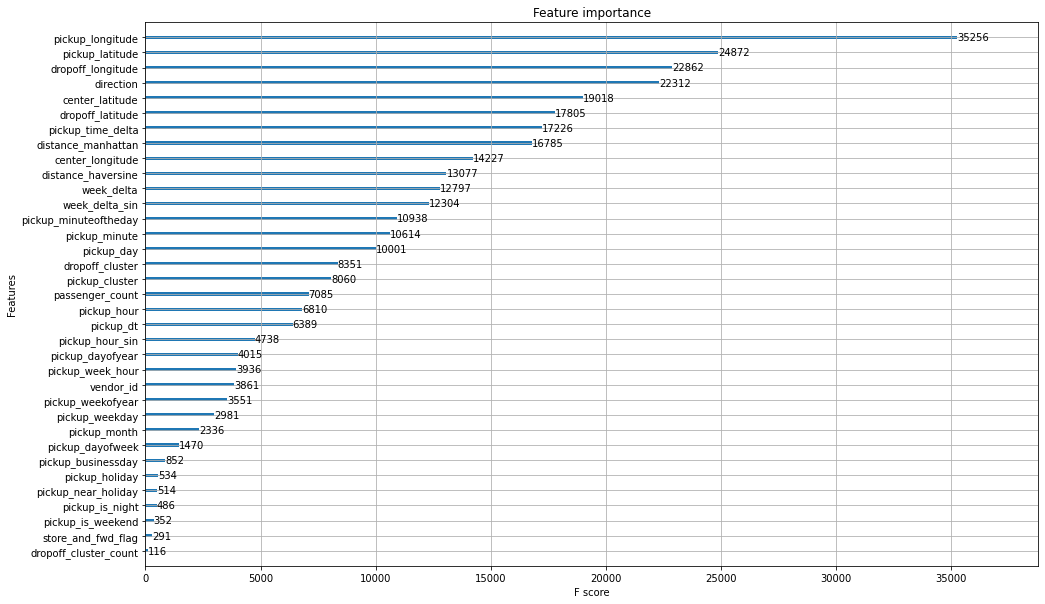

In [52]:
xgb.plot_importance(model2)

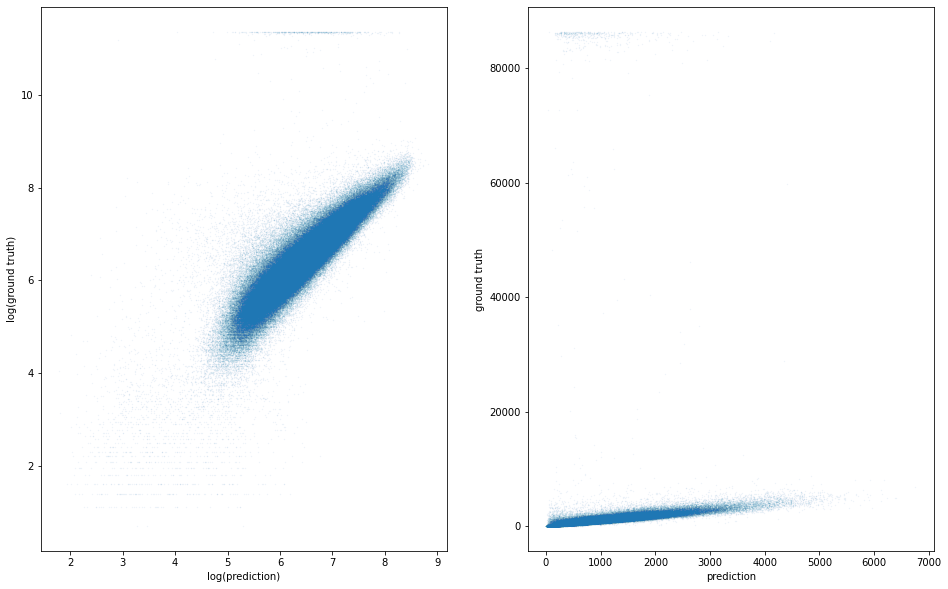

In [53]:
ypred2 = model2.predict(dtest1)
fig,ax = plt.subplots(ncols=2)
ax[0].scatter(ypred2, y_test, s=0.1, alpha=0.1)
ax[0].set_xlabel('log(prediction)')
ax[0].set_ylabel('log(ground truth)')
ax[1].scatter(np.exp(ypred1), np.exp(y_test), s=0.1, alpha=0.1)
ax[1].set_xlabel('prediction')
ax[1].set_ylabel('ground truth')
plt.show()

Test shape OK.
Valid prediction mean: 6.456
Test prediction mean: 6.455


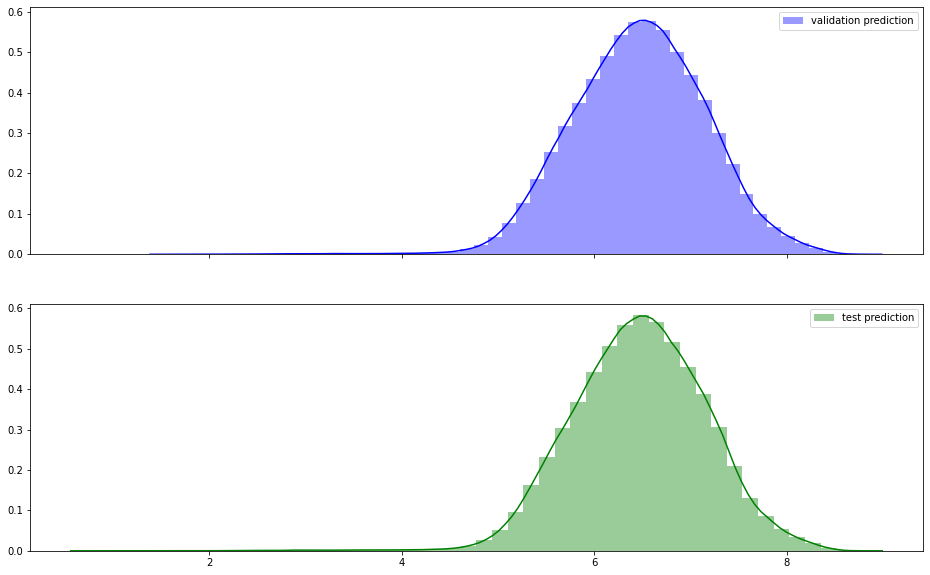

Total time: 514 seconds


In [54]:
ytest2 = model2.predict(ftest1)
print('Test shape OK.') if test_df.shape[0] == ytest2.shape[0] else print('Oops')
test_df['trip_duration'] = np.exp(ytest2) - 1
test_df[['id', 'trip_duration']].to_csv('/content/drive/My Drive/dt/model2.csv', index=False)

print('Valid prediction mean: %.3f' % ypred2.mean())
print('Test prediction mean: %.3f' % ytest2.mean())

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
sns.distplot(ypred1, ax=ax[0], color='blue', label='validation prediction')
sns.distplot(ytest1, ax=ax[1], color='green', label='test prediction')
ax[0].legend(loc=0)
ax[1].legend(loc=0)
plt.show()

t1 = dt.datetime.now()
print('Total time: %i seconds' % (t1 - t0).seconds)

## Model3

In [61]:
model3 = xgb.train(xgb_pars2, dtrain1, 100, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)

[0]	train-rmse:5.42174	valid-rmse:5.42094
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:1.93164	valid-rmse:1.93334
[20]	train-rmse:0.759005	valid-rmse:0.772747
[30]	train-rmse:0.416418	valid-rmse:0.455251
[40]	train-rmse:0.334927	valid-rmse:0.395381
[50]	train-rmse:0.309337	valid-rmse:0.385059
[60]	train-rmse:0.296133	valid-rmse:0.382639
[70]	train-rmse:0.285905	valid-rmse:0.381058
[80]	train-rmse:0.277484	valid-rmse:0.380077
[90]	train-rmse:0.270149	valid-rmse:0.379285
[99]	train-rmse:0.263699	valid-rmse:0.378528


In [62]:
print('Modeling RMSLE %.5f' % model3.best_score)

Modeling RMSLE 0.37853


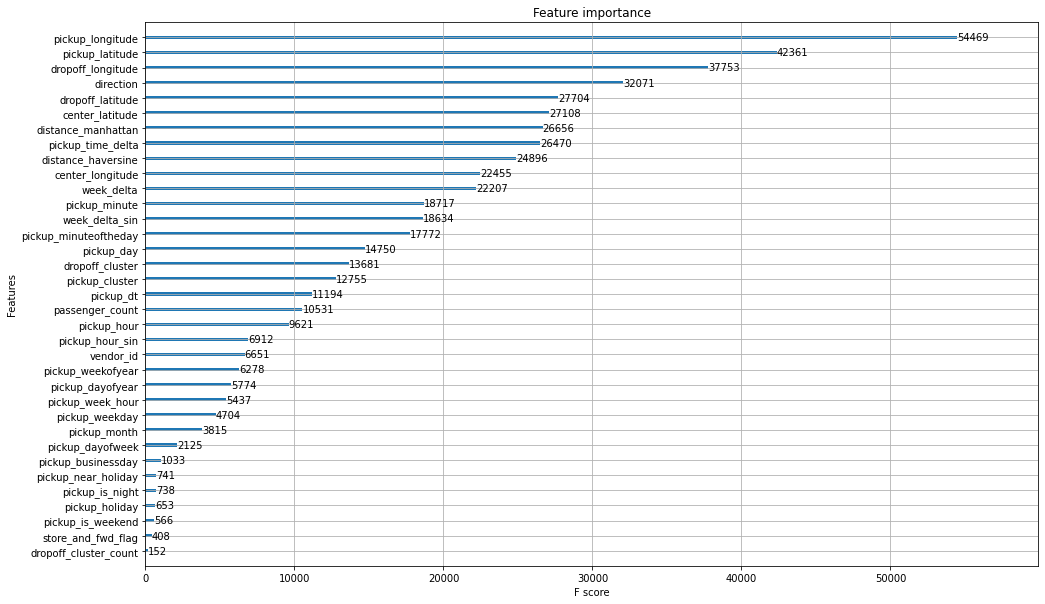

In [63]:
xgb.plot_importance(model3)

In [64]:
ypred3 = model3.predict(dtest1)

In [65]:
ytest3 = model3.predict(ftest1)

In [66]:
print('Test shape OK.') if test_df.shape[0] == ytest3.shape[0] else print('Oops')
test_df['trip_duration'] = np.exp(ytest3) - 1
test_df[['id', 'trip_duration']].to_csv('/content/drive/My Drive/dt/model3.csv', index=False)

Test shape OK.


## Light GBM

In [55]:
import lightgbm as lgbm

In [56]:
lgb_params = {
    'metric' : 'rmse',
    'learning_rate': 0.1,
    'max_depth': 25,
    'num_leaves': 1000, 
    'objective': 'regression',
    'feature_fraction': 0.9,
    'bagging_fraction': 0.5,
    'max_bin': 1000 }

In [74]:
lgb_df = lgbm.Dataset(train_df[features],train_df[target])

In [75]:
lgb_model = lgbm.train(lgb_params, lgb_df, num_boost_round=1500)

Exception ignored in: <bound method Booster.__del__ of <xgboost.core.Booster object at 0x7feeca679390>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/xgboost/core.py", line 957, in __del__
    if self.handle is not None:
AttributeError: 'Booster' object has no attribute 'handle'


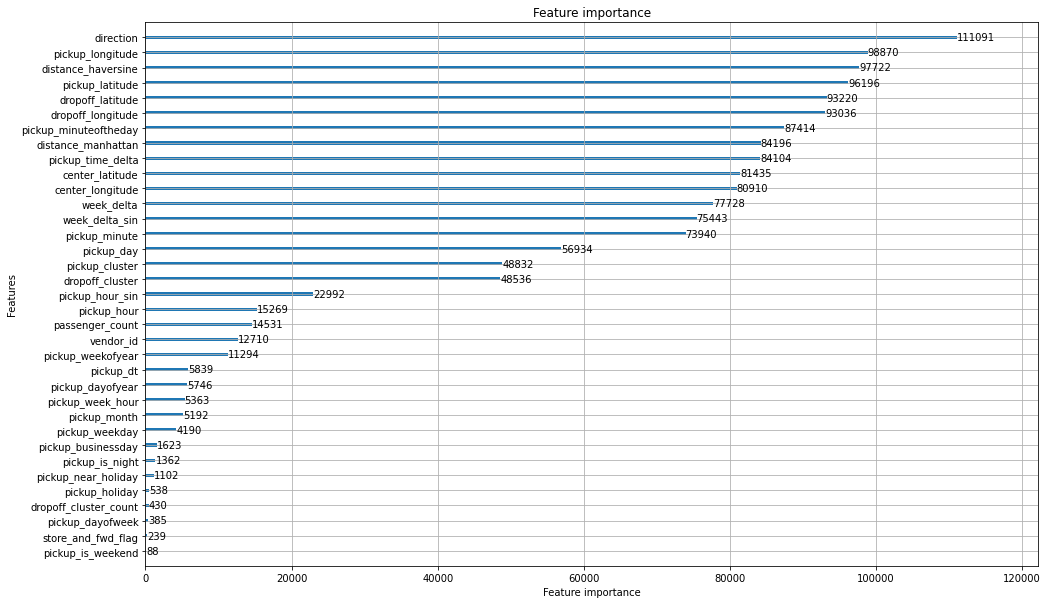

In [77]:
lgbm.plot_importance(lgb_model)

In [ ]:
pred = lgb_model.predict(test_df)

In [ ]:
pred_lgb = np.exp(pred)

In [78]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=1000, min_samples_leaf=50, min_samples_split=75)

In [ ]:
rf_model.fit(train_df[features], train_df[target])
predictions=rf_model.predict(test_df.values)
predictions[:5]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.
